<a href="https://colab.research.google.com/github/namoshi/colab/blob/master/pytorch_CV.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [69]:
#Import the packages needed.
import torch
import torchvision
import matplotlib.pyplot as plt
import numpy as np

In [70]:
from torchvision.transforms import ToTensor

data_train = torchvision.datasets.MNIST('./data',
        download=True,train=True,transform=ToTensor())
data_test = torchvision.datasets.MNIST('./data',
        download=True,train=False,transform=ToTensor())

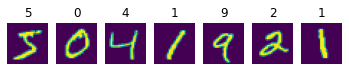

In [71]:
fig,ax = plt.subplots(1,7)
for i in range(7):
    ax[i].imshow(data_train[i][0].view(28,28))
    ax[i].set_title(data_train[i][1])
    ax[i].axis('off')

In [72]:
print('Training samples:',len(data_train))
print('Test samples:',len(data_test))

print('Tensor size:',data_train[0][0].size())
print('First 10 digits are:', [data_train[i][1] for i in range(10)])

Training samples: 60000
Test samples: 10000
Tensor size: torch.Size([1, 28, 28])
First 10 digits are: [5, 0, 4, 1, 9, 2, 1, 3, 1, 4]


In [73]:
print('Min intensity value: ',data_train[0][0].min().item())
print('Max intensity value: ',data_train[0][0].max().item())

Min intensity value:  0.0
Max intensity value:  1.0


In [74]:
!wget https://raw.githubusercontent.com/MicrosoftDocs/pytorchfundamentals/main/computer-vision-pytorch/pytorchcv.py

--2022-01-01 01:48:30--  https://raw.githubusercontent.com/MicrosoftDocs/pytorchfundamentals/main/computer-vision-pytorch/pytorchcv.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6371 (6.2K) [text/plain]
Saving to: ‘pytorchcv.py.1’

pytorchcv.py.1      100%[===================>]   6.22K  --.-KB/s    in 0s      

2022-01-01 01:48:30 (54.9 MB/s) - ‘pytorchcv.py.1’ saved [6371/6371]



# Fully-Connected Network (Logistic Regression)


In [75]:
import torch
import torch.nn as nn
import torchvision
import matplotlib.pyplot as plt

import pytorchcv
pytorchcv.load_mnist()

In [76]:
net = nn.Sequential(
        nn.Flatten(), 
        nn.Linear(784,10), # 784 inputs, 10 outputs
        nn.LogSoftmax())

In [77]:
print('Digit to be predicted: ',data_train[0][1])
torch.exp(net(data_train[0][0]))

Digit to be predicted:  5


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


tensor([[0.0981, 0.1125, 0.0844, 0.1203, 0.0749, 0.1492, 0.0843, 0.1055, 0.0784,
         0.0925]], grad_fn=<ExpBackward0>)

In [78]:
train_loader = torch.utils.data.DataLoader(data_train,batch_size=64)
test_loader = torch.utils.data.DataLoader(data_test,batch_size=64) # we can use larger batch size for testing

In [79]:
def train_epoch(net,dataloader,lr=0.01,optimizer=None,loss_fn = nn.NLLLoss()):
    optimizer = optimizer or torch.optim.Adam(net.parameters(),lr=lr)
    net.train()
    total_loss,acc,count = 0,0,0
    for features,labels in dataloader:
        optimizer.zero_grad()
        out = net(features)
        loss = loss_fn(out,labels) #cross_entropy(out,labels)
        loss.backward()
        optimizer.step()
        total_loss+=loss
        _,predicted = torch.max(out,1)
        acc+=(predicted==labels).sum()
        count+=len(labels)
    return total_loss.item()/count, acc.item()/count

train_epoch(net,train_loader)

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


(0.005929408264160156, 0.8929833333333334)

In [80]:
def validate(net, dataloader,loss_fn=nn.NLLLoss()):
    net.eval()
    count,acc,loss = 0,0,0
    with torch.no_grad():
        for features,labels in dataloader:
            out = net(features)
            loss += loss_fn(out,labels) 
            pred = torch.max(out,1)[1]
            acc += (pred==labels).sum()
            count += len(labels)
    return loss.item()/count, acc.item()/count

validate(net,test_loader)

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


(0.005857783126831054, 0.8938)

In [81]:
def train(net,train_loader,test_loader,optimizer=None,lr=0.01,epochs=10,loss_fn=nn.NLLLoss()):
    optimizer = optimizer or torch.optim.Adam(net.parameters(),lr=lr)
    res = { 'train_loss' : [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
    for ep in range(epochs):
        tl,ta = train_epoch(net,train_loader,optimizer=optimizer,lr=lr,loss_fn=loss_fn)
        vl,va = validate(net,test_loader,loss_fn=loss_fn)
        print(f"Epoch {ep:2}, Train acc={ta:.3f}, Val acc={va:.3f}, Train loss={tl:.3f}, Val loss={vl:.3f}")
        res['train_loss'].append(tl)
        res['train_acc'].append(ta)
        res['val_loss'].append(vl)
        res['val_acc'].append(va)
    return res

# Re-initialize the network to start from scratch
net = nn.Sequential(
        nn.Flatten(), 
        nn.Linear(784,10), # 784 inputs, 10 outputs
        nn.LogSoftmax())

hist = train(net,train_loader,test_loader,epochs=20)

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Epoch  0, Train acc=0.893, Val acc=0.893, Train loss=0.006, Val loss=0.006
Epoch  1, Train acc=0.910, Val acc=0.899, Train loss=0.005, Val loss=0.006
Epoch  2, Train acc=0.913, Val acc=0.899, Train loss=0.005, Val loss=0.006
Epoch  3, Train acc=0.915, Val acc=0.897, Train loss=0.005, Val loss=0.006
Epoch  4, Train acc=0.916, Val acc=0.896, Train loss=0.005, Val loss=0.006
Epoch  5, Train acc=0.917, Val acc=0.895, Train loss=0.005, Val loss=0.006
Epoch  6, Train acc=0.918, Val acc=0.893, Train loss=0.005, Val loss=0.007
Epoch  7, Train acc=0.919, Val acc=0.892, Train loss=0.005, Val loss=0.007
Epoch  8, Train acc=0.919, Val acc=0.891, Train loss=0.005, Val loss=0.007
Epoch  9, Train acc=0.919, Val acc=0.890, Train loss=0.005, Val loss=0.007
Epoch 10, Train acc=0.920, Val acc=0.890, Train loss=0.005, Val loss=0.007
Epoch 11, Train acc=0.920, Val acc=0.890, Train loss=0.005, Val loss=0.007
Epoch 12, Train acc=0.920, Val acc=0.890, Train loss=0.005, Val loss=0.007
Epoch 13, Train acc=0.920

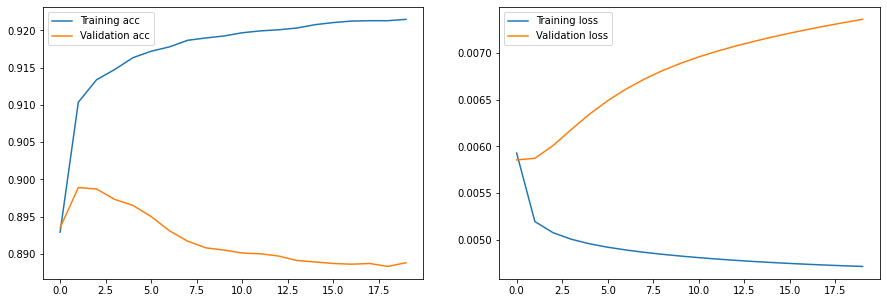

In [82]:
plt.figure(figsize=(15,5))
plt.subplot(121)
plt.plot(hist['train_acc'], label='Training acc')
plt.plot(hist['val_acc'], label='Validation acc')
plt.legend()
plt.subplot(122)
plt.plot(hist['train_loss'], label='Training loss')
plt.plot(hist['val_loss'], label='Validation loss')
plt.legend()


### Visualizing network weights


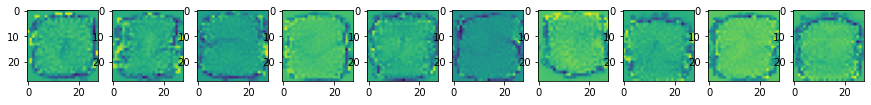

In [83]:
weight_tensor = next(net.parameters())
fig,ax = plt.subplots(1,10,figsize=(15,4))
for i,x in enumerate(weight_tensor):
    ax[i].imshow(x.view(28,28).detach())

# Training a multi-Layered perceptron

In [84]:
!pip install torchinfo

In [85]:
import torch
import torch.nn as nn
import torchvision
import matplotlib.pyplot as plt
from torchinfo import summary

from pytorchcv import load_mnist, train, plot_results
load_mnist(batch_size=128)

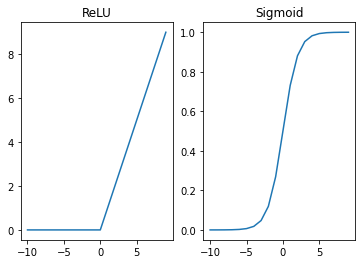

In [86]:
def plot_function(f,name=''):
    plt.plot(range(-10,10), [f(torch.tensor(x,dtype=torch.float32)).item() for x in range(-10,10)])
    plt.title(name)

plt.subplot(121)
plot_function(torch.relu,'ReLU')
plt.subplot(122)
plot_function(torch.sigmoid,'Sigmoid')

In [87]:
net = nn.Sequential(
        nn.Flatten(), 
        nn.Linear(784,100),     # 784 inputs, 100 outputs
        nn.ReLU(),              # Activation Function
        nn.Linear(100,10),      # 100 inputs, 10 outputs
        nn.LogSoftmax(dim=0))

summary(net,input_size=(1,28,28))

Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               --                        --
├─Flatten: 1-1                           [1, 784]                  --
├─Linear: 1-2                            [1, 100]                  78,500
├─ReLU: 1-3                              [1, 100]                  --
├─Linear: 1-4                            [1, 10]                   1,010
├─LogSoftmax: 1-5                        [1, 10]                   --
Total params: 79,510
Trainable params: 79,510
Non-trainable params: 0
Total mult-adds (M): 0.08
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.32
Estimated Total Size (MB): 0.32

Epoch  0, Train acc=0.927, Val acc=0.944, Train loss=0.035, Val loss=0.034
Epoch  1, Train acc=0.953, Val acc=0.955, Train loss=0.033, Val loss=0.033
Epoch  2, Train acc=0.958, Val acc=0.958, Train loss=0.033, Val loss=0.033
Epoch  3, Train acc=0.962, Val acc=0.957, Train loss=0.033, Val loss=0.033
Epoch  4, Train acc=0.963, Val acc=0.958, Train loss=0.033, Val loss=0.033


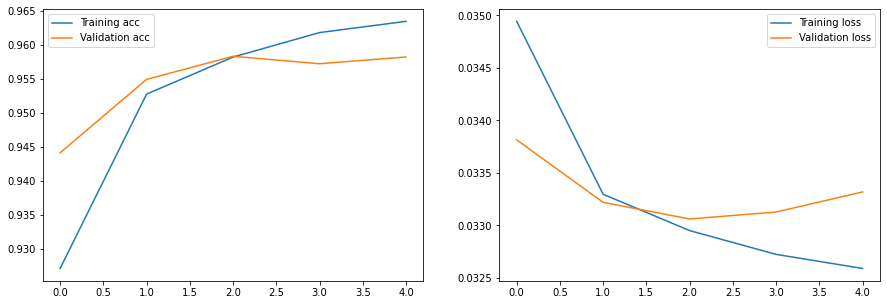

In [88]:
hist = train(net,train_loader,test_loader, epochs=5)
plot_results(hist)

In [89]:
from torch.nn.functional import relu,log_softmax

class MyNet(nn.Module):
    def __init__(self):
        super(MyNet, self).__init__()
        self.flatten = nn.Flatten()
        self.hidden = nn.Linear(784,100)
        self.out = nn.Linear(100,10)

    def forward(self, x):
        x = self.flatten(x)
        x = self.hidden(x)
        x = relu(x)
        x = self.out(x)
        x = log_softmax(x,dim=0)
        return x

net = MyNet()

summary(net,input_size=(1,28,28))

Layer (type:depth-idx)                   Output Shape              Param #
MyNet                                    --                        --
├─Flatten: 1-1                           [1, 784]                  --
├─Linear: 1-2                            [1, 100]                  78,500
├─Linear: 1-3                            [1, 10]                   1,010
Total params: 79,510
Trainable params: 79,510
Non-trainable params: 0
Total mult-adds (M): 0.08
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.32
Estimated Total Size (MB): 0.32

Epoch  0, Train acc=0.927, Val acc=0.946, Train loss=0.035, Val loss=0.034
Epoch  1, Train acc=0.953, Val acc=0.954, Train loss=0.033, Val loss=0.033
Epoch  2, Train acc=0.958, Val acc=0.960, Train loss=0.033, Val loss=0.033
Epoch  3, Train acc=0.961, Val acc=0.956, Train loss=0.033, Val loss=0.033
Epoch  4, Train acc=0.964, Val acc=0.957, Train loss=0.033, Val loss=0.033
Epoch  5, Train acc=0.965, Val acc=0.954, Train loss=0.033, Val loss=0.033
Epoch  6, Train acc=0.965, Val acc=0.955, Train loss=0.033, Val loss=0.033
Epoch  7, Train acc=0.967, Val acc=0.954, Train loss=0.032, Val loss=0.034
Epoch  8, Train acc=0.968, Val acc=0.957, Train loss=0.032, Val loss=0.033
Epoch  9, Train acc=0.968, Val acc=0.954, Train loss=0.032, Val loss=0.033
Epoch 10, Train acc=0.969, Val acc=0.955, Train loss=0.032, Val loss=0.033
Epoch 11, Train acc=0.969, Val acc=0.954, Train loss=0.032, Val loss=0.034
Epoch 12, Train acc=0.968, Val acc=0.955, Train loss=0.032, Val loss=0.034
Epoch 13, Train acc=0.968

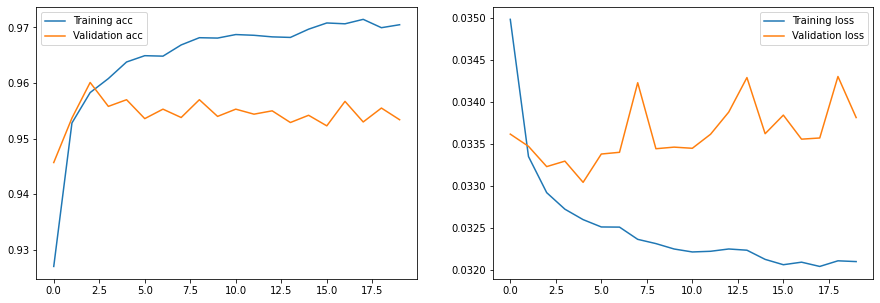

In [90]:
hist = train(net,train_loader,test_loader,epochs=20)
plot_results(hist)

# Use a convolutional neural network

In [91]:
import torch
import torch.nn as nn
import torchvision
import matplotlib.pyplot as plt
from torchinfo import summary
import numpy as np

from pytorchcv import load_mnist, train, plot_results, plot_convolution, display_dataset
load_mnist(batch_size=128)

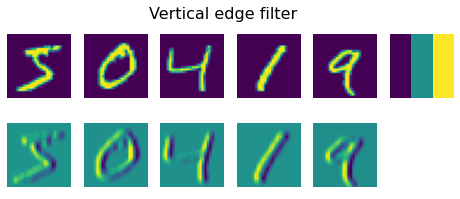

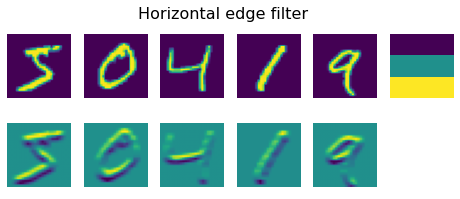

In [92]:
plot_convolution(torch.tensor([[-1.,0.,1.],[-1.,0.,1.],[-1.,0.,1.]]),'Vertical edge filter')
plot_convolution(torch.tensor([[-1.,-1.,-1.],[0.,0.,0.],[1.,1.,1.]]),'Horizontal edge filter')


In [93]:
class OneConv(nn.Module):
    def __init__(self):
        super(OneConv, self).__init__()
        self.conv = nn.Conv2d(in_channels=1,out_channels=9,kernel_size=(5,5))
        self.flatten = nn.Flatten()
        self.fc = nn.Linear(5184,10)

    def forward(self, x):
        x = nn.functional.relu(self.conv(x))
        x = self.flatten(x)
        x = nn.functional.log_softmax(self.fc(x),dim=1)
        return x

net = OneConv()

summary(net,input_size=(1,1,28,28))

Layer (type:depth-idx)                   Output Shape              Param #
OneConv                                  --                        --
├─Conv2d: 1-1                            [1, 9, 24, 24]            234
├─Flatten: 1-2                           [1, 5184]                 --
├─Linear: 1-3                            [1, 10]                   51,850
Total params: 52,084
Trainable params: 52,084
Non-trainable params: 0
Total mult-adds (M): 0.19
Input size (MB): 0.00
Forward/backward pass size (MB): 0.04
Params size (MB): 0.21
Estimated Total Size (MB): 0.25

Epoch  0, Train acc=0.951, Val acc=0.961, Train loss=0.003, Val loss=0.002
Epoch  1, Train acc=0.977, Val acc=0.974, Train loss=0.001, Val loss=0.001
Epoch  2, Train acc=0.983, Val acc=0.973, Train loss=0.001, Val loss=0.002
Epoch  3, Train acc=0.985, Val acc=0.974, Train loss=0.001, Val loss=0.002
Epoch  4, Train acc=0.988, Val acc=0.976, Train loss=0.001, Val loss=0.002


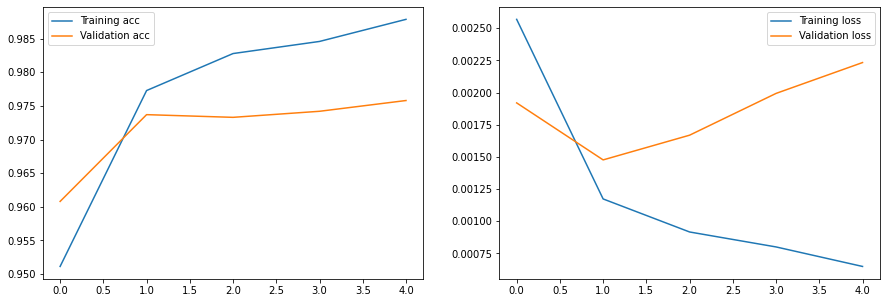

In [94]:
hist = train(net,train_loader,test_loader,epochs=5)
plot_results(hist)

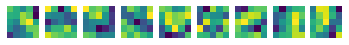

In [95]:
fig,ax = plt.subplots(1,9)
with torch.no_grad():
    p = next(net.conv.parameters())
    for i,x in enumerate(p):
        ax[i].imshow(x.detach().cpu()[0,...])
        ax[i].axis('off')

### Multi-layered CNNs and pooling layers

In [96]:
class MultiLayerCNN(nn.Module):
    def __init__(self):
        super(MultiLayerCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(10, 20, 5)
        self.fc = nn.Linear(320,10)

    def forward(self, x):
        x = self.pool(nn.functional.relu(self.conv1(x)))
        x = self.pool(nn.functional.relu(self.conv2(x)))
        x = x.view(-1, 320)
        x = nn.functional.log_softmax(self.fc(x),dim=1)
        return x

net = MultiLayerCNN()
summary(net,input_size=(1,1,28,28))

Layer (type:depth-idx)                   Output Shape              Param #
MultiLayerCNN                            --                        --
├─Conv2d: 1-1                            [1, 10, 24, 24]           260
├─MaxPool2d: 1-2                         [1, 10, 12, 12]           --
├─Conv2d: 1-3                            [1, 20, 8, 8]             5,020
├─MaxPool2d: 1-4                         [1, 20, 4, 4]             --
├─Linear: 1-5                            [1, 10]                   3,210
Total params: 8,490
Trainable params: 8,490
Non-trainable params: 0
Total mult-adds (M): 0.47
Input size (MB): 0.00
Forward/backward pass size (MB): 0.06
Params size (MB): 0.03
Estimated Total Size (MB): 0.09

In [97]:
hist = train(net,train_loader,test_loader,epochs=5)

Epoch  0, Train acc=0.957, Val acc=0.976, Train loss=0.002, Val loss=0.001
Epoch  1, Train acc=0.980, Val acc=0.979, Train loss=0.001, Val loss=0.001
Epoch  2, Train acc=0.982, Val acc=0.978, Train loss=0.001, Val loss=0.001
Epoch  3, Train acc=0.982, Val acc=0.982, Train loss=0.001, Val loss=0.001
Epoch  4, Train acc=0.984, Val acc=0.983, Train loss=0.001, Val loss=0.001


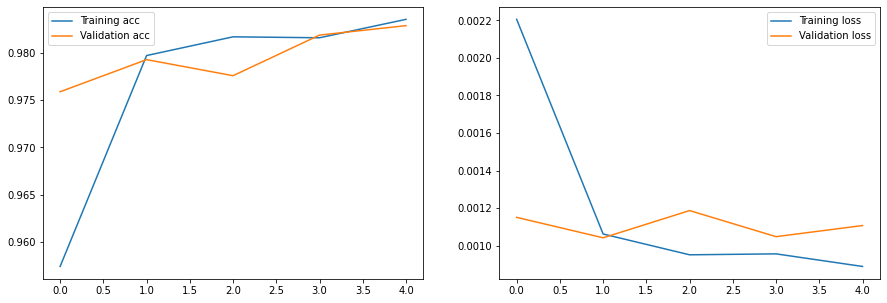

In [98]:
plot_results(hist)

### Playing with real images from the CIFAR-10 dataset

In [99]:
transform = torchvision.transforms.Compose(
    [torchvision.transforms.ToTensor(),
     torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=14, shuffle=True)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=14, shuffle=False)
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


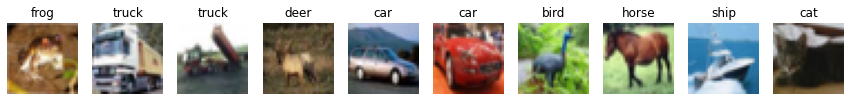

In [100]:
display_dataset(trainset,classes=classes)

In [101]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.conv3 = nn.Conv2d(16,120,5)
        self.flat = nn.Flatten()
        self.fc1 = nn.Linear(120,64)
        self.fc2 = nn.Linear(64,10)

    def forward(self, x):
        x = self.pool(nn.functional.relu(self.conv1(x)))
        x = self.pool(nn.functional.relu(self.conv2(x)))
        x = nn.functional.relu(self.conv3(x))
        x = self.flat(x)
        x = nn.functional.relu(self.fc1(x))
        x = self.fc2(x)
        return x

net = LeNet()

summary(net,input_size=(1,3,32,32))

Layer (type:depth-idx)                   Output Shape              Param #
LeNet                                    --                        --
├─Conv2d: 1-1                            [1, 6, 28, 28]            456
├─MaxPool2d: 1-2                         [1, 6, 14, 14]            --
├─Conv2d: 1-3                            [1, 16, 10, 10]           2,416
├─MaxPool2d: 1-4                         [1, 16, 5, 5]             --
├─Conv2d: 1-5                            [1, 120, 1, 1]            48,120
├─Flatten: 1-6                           [1, 120]                  --
├─Linear: 1-7                            [1, 64]                   7,744
├─Linear: 1-8                            [1, 10]                   650
Total params: 59,386
Trainable params: 59,386
Non-trainable params: 0
Total mult-adds (M): 0.66
Input size (MB): 0.01
Forward/backward pass size (MB): 0.05
Params size (MB): 0.24
Estimated Total Size (MB): 0.30

Epoch  0, Train acc=0.265, Val acc=0.380, Train loss=0.143, Val loss=0.120
Epoch  1, Train acc=0.437, Val acc=0.492, Train loss=0.110, Val loss=0.101
Epoch  2, Train acc=0.509, Val acc=0.531, Train loss=0.097, Val loss=0.093
Epoch  3, Train acc=0.558, Val acc=0.561, Train loss=0.089, Val loss=0.088
Epoch  4, Train acc=0.590, Val acc=0.593, Train loss=0.083, Val loss=0.082
Epoch  5, Train acc=0.614, Val acc=0.601, Train loss=0.078, Val loss=0.081
Epoch  6, Train acc=0.634, Val acc=0.616, Train loss=0.074, Val loss=0.077
Epoch  7, Train acc=0.654, Val acc=0.622, Train loss=0.070, Val loss=0.077
Epoch  8, Train acc=0.667, Val acc=0.614, Train loss=0.068, Val loss=0.078
Epoch  9, Train acc=0.679, Val acc=0.633, Train loss=0.065, Val loss=0.074


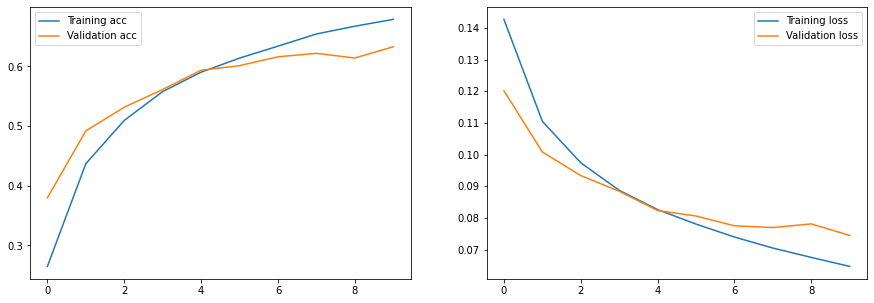

In [102]:
opt = torch.optim.SGD(net.parameters(),lr=0.001,momentum=0.9)
hist = train(net, trainloader, testloader, epochs=10, optimizer=opt, loss_fn=nn.CrossEntropyLoss())
plot_results(hist)

### Use a pre-trained network with transfer learning

In [103]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from torchinfo import summary
import numpy as np
import os

from pytorchcv import train, plot_results, display_dataset, train_long, check_image_dir

In [104]:
if not os.path.exists('data/kagglecatsanddogs_3367a.zip'):
    !wget -P data -q https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_3367a.zip

In [105]:
import zipfile
if not os.path.exists('data/PetImages'):
    with zipfile.ZipFile('data/kagglecatsanddogs_3367a.zip', 'r') as zip_ref:
        zip_ref.extractall('data')

In [106]:
check_image_dir('data/PetImages/Cat/*.jpg')
check_image_dir('data/PetImages/Dog/*.jpg')

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 32 bytes but only got 0. Skipping tag 270
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 5 bytes but only got 0. Skipping tag 271
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 272
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 282
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only

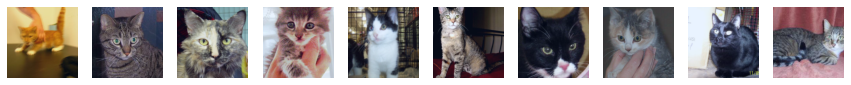

In [107]:
std_normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                          std=[0.229, 0.224, 0.225])
trans = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(), 
        std_normalize])
dataset = torchvision.datasets.ImageFolder('data/PetImages',transform=trans)
trainset, testset = torch.utils.data.random_split(dataset,[20000,len(dataset)-20000])

display_dataset(dataset)

In [108]:
vgg = torchvision.models.vgg16(pretrained=True)
sample_image = dataset[0][0].unsqueeze(0)
res = vgg(sample_image)
print(res[0].argmax())

tensor(282)


In [109]:
import json, requests
class_map = json.loads(requests.get("https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json").text)
class_map = { int(k) : v for k,v in class_map.items() }

class_map[res[0].argmax().item()]

['n02123159', 'tiger_cat']

In [110]:
summary(vgg,input_size=(1,3,224,224))

Layer (type:depth-idx)                   Output Shape              Param #
VGG                                      --                        --
├─Sequential: 1-1                        [1, 512, 7, 7]            --
│    └─Conv2d: 2-1                       [1, 64, 224, 224]         1,792
│    └─ReLU: 2-2                         [1, 64, 224, 224]         --
│    └─Conv2d: 2-3                       [1, 64, 224, 224]         36,928
│    └─ReLU: 2-4                         [1, 64, 224, 224]         --
│    └─MaxPool2d: 2-5                    [1, 64, 112, 112]         --
│    └─Conv2d: 2-6                       [1, 128, 112, 112]        73,856
│    └─ReLU: 2-7                         [1, 128, 112, 112]        --
│    └─Conv2d: 2-8                       [1, 128, 112, 112]        147,584
│    └─ReLU: 2-9                         [1, 128, 112, 112]        --
│    └─MaxPool2d: 2-10                   [1, 128, 56, 56]          --
│    └─Conv2d: 2-11                      [1, 256, 56, 56]          29

### GPU computations

In [111]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

print('Doing computations on device = {}'.format(device))

vgg.to(device)
sample_image = sample_image.to(device)

vgg(sample_image).argmax()

Doing computations on device = cuda


tensor(282, device='cuda:0')

torch.Size([1, 512, 7, 7])


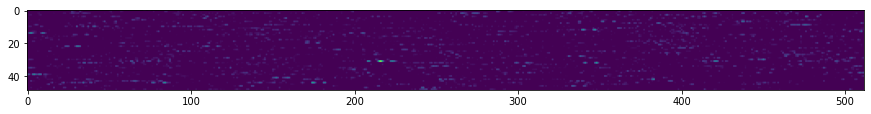

In [112]:
res = vgg.features(sample_image).cpu()
plt.figure(figsize=(15,3))
plt.imshow(res.detach().view(-1,512))
print(res.size())

In [113]:
bs = 8
dl = torch.utils.data.DataLoader(dataset,batch_size=bs,shuffle=True)
num = bs*100
feature_tensor = torch.zeros(num,512*7*7).to(device)
label_tensor = torch.zeros(num).to(device)
i = 0
for x,l in dl:
    with torch.no_grad():
        f = vgg.features(x.to(device))
        feature_tensor[i:i+bs] = f.view(bs,-1)
        label_tensor[i:i+bs] = l
        i+=bs
        print('.',end='')
        if i>=num:
            break

....................................................................................................

In [114]:
vgg_dataset = torch.utils.data.TensorDataset(feature_tensor,label_tensor.to(torch.long))
train_ds, test_ds = torch.utils.data.random_split(vgg_dataset,[700,100])

train_loader = torch.utils.data.DataLoader(train_ds,batch_size=32)
test_loader = torch.utils.data.DataLoader(test_ds,batch_size=32)

net = torch.nn.Sequential(torch.nn.Linear(512*7*7,2),torch.nn.LogSoftmax()).to(device)

history = train(net,train_loader,test_loader)

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Epoch  0, Train acc=0.909, Val acc=0.990, Train loss=0.064, Val loss=0.001
Epoch  1, Train acc=0.983, Val acc=0.980, Train loss=0.016, Val loss=0.008
Epoch  2, Train acc=0.994, Val acc=0.990, Train loss=0.003, Val loss=0.010
Epoch  3, Train acc=1.000, Val acc=0.990, Train loss=0.000, Val loss=0.007
Epoch  4, Train acc=1.000, Val acc=0.990, Train loss=0.000, Val loss=0.006
Epoch  5, Train acc=1.000, Val acc=0.990, Train loss=0.000, Val loss=0.006
Epoch  6, Train acc=1.000, Val acc=0.990, Train loss=0.000, Val loss=0.006
Epoch  7, Train acc=1.000, Val acc=0.990, Train loss=0.000, Val loss=0.006
Epoch  8, Train acc=1.000, Val acc=0.990, Train loss=0.000, Val loss=0.006
Epoch  9, Train acc=1.000, Val acc=0.990, Train loss=0.000, Val loss=0.006


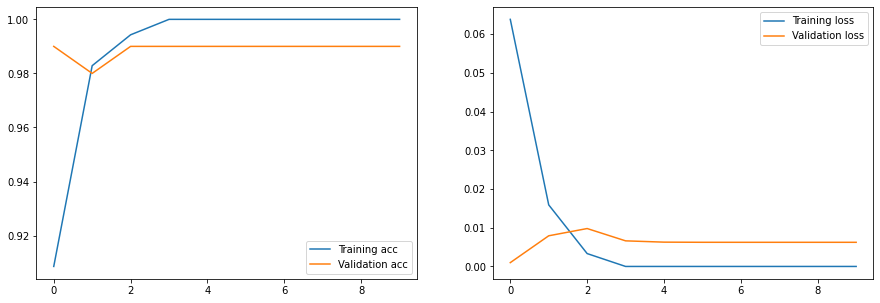

In [115]:
plot_results(history)

In [116]:
print(vgg)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [117]:
vgg.classifier = torch.nn.Linear(25088,2).to(device)

for x in vgg.features.parameters():
    x.requires_grad = False

summary(vgg,(1, 3,244,244))

Layer (type:depth-idx)                   Output Shape              Param #
VGG                                      --                        --
├─Sequential: 1-1                        [1, 512, 7, 7]            --
│    └─Conv2d: 2-1                       [1, 64, 244, 244]         (1,792)
│    └─ReLU: 2-2                         [1, 64, 244, 244]         --
│    └─Conv2d: 2-3                       [1, 64, 244, 244]         (36,928)
│    └─ReLU: 2-4                         [1, 64, 244, 244]         --
│    └─MaxPool2d: 2-5                    [1, 64, 122, 122]         --
│    └─Conv2d: 2-6                       [1, 128, 122, 122]        (73,856)
│    └─ReLU: 2-7                         [1, 128, 122, 122]        --
│    └─Conv2d: 2-8                       [1, 128, 122, 122]        (147,584)
│    └─ReLU: 2-9                         [1, 128, 122, 122]        --
│    └─MaxPool2d: 2-10                   [1, 128, 61, 61]          --
│    └─Conv2d: 2-11                      [1, 256, 61, 61]    

In [118]:
trainset, testset = torch.utils.data.random_split(dataset,[20000,len(dataset)-20000])
train_loader = torch.utils.data.DataLoader(trainset,batch_size=16)
test_loader = torch.utils.data.DataLoader(testset,batch_size=16)

train_long(vgg,train_loader,test_loader,loss_fn=torch.nn.CrossEntropyLoss(),epochs=10,print_freq=90)

Epoch 0, minibatch 0: train acc = 0.5625, train loss = 0.0508790984749794
Epoch 0, minibatch 90: train acc = 0.9546703296703297, train loss = 0.07639181744921339
Epoch 0, minibatch 180: train acc = 0.9620165745856354, train loss = 0.09219541602371806
Epoch 0, minibatch 270: train acc = 0.9647140221402214, train loss = 0.11505459859362388
Epoch 0, minibatch 360: train acc = 0.9662396121883656, train loss = 0.12824679345635495
Epoch 0, minibatch 450: train acc = 0.9689578713968958, train loss = 0.12834319730027025
Epoch 0, minibatch 540: train acc = 0.9704251386321626, train loss = 0.12794122325735038
Epoch 0, minibatch 630: train acc = 0.9715729001584786, train loss = 0.12673283983523798
Epoch 0, minibatch 720: train acc = 0.9720873786407767, train loss = 0.13022239991927445


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 32 bytes but only got 0. Skipping tag 270
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 5 bytes but only got 0. Skipping tag 271
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 272
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 282
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only

Epoch 0, minibatch 810: train acc = 0.9726418002466092, train loss = 0.1316404424966043
Epoch 0, minibatch 900: train acc = 0.9730854605993341, train loss = 0.138056281933377
Epoch 0, minibatch 990: train acc = 0.973574672048436, train loss = 0.14218874102764725
Epoch 0, minibatch 1080: train acc = 0.9736355226641998, train loss = 0.15017208978051283
Epoch 0, minibatch 1170: train acc = 0.9743274978650726, train loss = 0.14982260973610295
Epoch 0 done, validation acc = 0.9805922368947579, validation loss = 0.15333285413774886
Epoch 1, minibatch 0: train acc = 1.0, train loss = 0.0
Epoch 1, minibatch 90: train acc = 0.9862637362637363, train loss = 0.16228649642441298
Epoch 1, minibatch 180: train acc = 0.9896408839779005, train loss = 0.10188824564053868
Epoch 1, minibatch 270: train acc = 0.988929889298893, train loss = 0.09615798893889818
Epoch 1, minibatch 360: train acc = 0.9870152354570637, train loss = 0.10953930672516123
Epoch 1, minibatch 450: train acc = 0.9869733924611973, tr

In [119]:
torch.save(vgg,'data/cats_dogs.pth')

In [120]:
vgg = torch.load('data/cats_dogs.pth')

### Fine-tuning transfer learning

In [121]:
for x in vgg.features.parameters():
    x.requires_grad = True

In [122]:
train_long(vgg,train_loader,test_loader,loss_fn=torch.nn.CrossEntropyLoss(),epochs=10,print_freq=90,lr=0.0001)

Epoch 0, minibatch 0: train acc = 1.0, train loss = 0.0
Epoch 0, minibatch 90: train acc = 0.875, train loss = 0.8054703094147064
Epoch 0, minibatch 180: train acc = 0.9005524861878453, train loss = 0.4602508544921875
Epoch 0, minibatch 270: train acc = 0.9165129151291513, train loss = 0.3276726698083631
Epoch 0, minibatch 360: train acc = 0.9260734072022161, train loss = 0.2571257065537894
Epoch 0, minibatch 450: train acc = 0.9307095343680709, train loss = 0.2187110917795524
Epoch 0, minibatch 540: train acc = 0.9317236598890942, train loss = 0.18884188498675053
Epoch 0, minibatch 630: train acc = 0.9344294770206022, train loss = 0.16659567662161995
Epoch 0, minibatch 720: train acc = 0.9353328710124826, train loss = 0.14987569906840542


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 32 bytes but only got 0. Skipping tag 270
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 5 bytes but only got 0. Skipping tag 271
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 272
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 282
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only

Epoch 0, minibatch 810: train acc = 0.937191738594328, train loss = 0.13634229441312326
Epoch 0, minibatch 900: train acc = 0.9391648168701443, train loss = 0.12471294508922377
Epoch 0, minibatch 990: train acc = 0.9407164480322906, train loss = 0.11468513558057675
Epoch 0, minibatch 1080: train acc = 0.9423566142460684, train loss = 0.1067129694456088
Epoch 0, minibatch 1170: train acc = 0.9438514090520922, train loss = 0.09940728400122091
Epoch 0 done, validation acc = 0.9617847138855542, validation loss = 0.014150050889496424
Epoch 1, minibatch 0: train acc = 1.0, train loss = 0.0010179559467360377
Epoch 1, minibatch 90: train acc = 0.9587912087912088, train loss = 0.011115101667550894
Epoch 1, minibatch 180: train acc = 0.9599447513812155, train loss = 0.009287087298229912
Epoch 1, minibatch 270: train acc = 0.959870848708487, train loss = 0.008653950427291139
Epoch 1, minibatch 360: train acc = 0.9629501385041551, train loss = 0.008105230463508754
Epoch 1, minibatch 450: train acc

### Other computer vision models

In [124]:
resnet = torchvision.models.resnet18()
print(resnet)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  